In [1]:


# Libraries
import os
import sys
import time
import random
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html
import imagesize
from sklearn.model_selection import StratifiedKFold

In [2]:


# Import the training data
train = pd.read_csv("./happy-whale-and-dolphin/train.csv")

# Adjust typos in "species" column
train["species"] = train["species"].replace(["bottlenose_dolpin", "kiler_whale",
                                             "beluga", 
                                             "globis", "pilot_whale"],
                                            ["bottlenose_dolphin", "killer_whale",
                                             "beluga_whale", 
                                             "short_finned_pilot_whale", "short_finned_pilot_whale"])
# Create a "class" column
train["class"] = train["species"].apply(lambda x: x.split("_")[-1])

# Create path to train images
TRAIN_PATH = "../input/happy-whale-and-dolphin/train_images/"
train["path"] = TRAIN_PATH + train["image"]


# --- Inspect ---
print("--- TEST ---")
print("Total Number of Samples:", len(os.listdir("./happy-whale-and-dolphin/test_images")), "\n")
print("--- TRAIN ---")
print("Number of Missing Values:", train.isna().sum().sum())
print("Data Shape:", train.shape)
train.head()



--- TEST ---
Total Number of Samples: 27956 

--- TRAIN ---
Number of Missing Values: 0
Data Shape: (51033, 5)


,image,species,individual_id,class,path
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,../input/happy-whale-and-dolphin/train_images/...
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,../input/happy-whale-and-dolphin/train_images/...
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,../input/happy-whale-and-dolphin/train_images/...
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,dolphin,../input/happy-whale-and-dolphin/train_images/...
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,whale,../input/happy-whale-and-dolphin/train_images/...


In [3]:
# Create a unique id column based on image name
train["image_code"] = train["image"].apply(lambda x: x.split(".")[0])

# Create a 'target' column
tmp = train.groupby('individual_id')['image_code'].agg('unique').to_dict()
train['target'] = train['individual_id'].map(tmp)

# Map the individual id to a unique key (integer, not string)
individual_mapping = train["individual_id"].value_counts().reset_index().drop(columns=["individual_id"])
individual_mapping.columns = ["individual_id"]
individual_mapping["individual_key"] = np.arange(start=0, stop=len(individual_mapping), step=1)

train['count'] = train.groupby('individual_id')['individual_id'].transform('count')
train_sorted = train.sort_values(by='count', ascending=False)
train_sorted['individual_key'] = 0
ind_id = "37c7aba965a5"
ind_key = 0
ind_map = {}
for idx, row in train_sorted.iterrows():
      if row["individual_id"] not in ind_map:
            ind_map[row["individual_id"]] = ind_key
            ind_key += 1
      train_sorted.at[idx, "individual_key"] = ind_map[row["individual_id"]]

train = train_sorted.drop(columns=["count"])
train = train.sort_index()


# Add Validation Fold
### based on individual key group
skf = StratifiedKFold(n_splits=5)
skf_splits = skf.split(X=train.drop(columns="individual_key"), y=train["individual_key"])

for fold, (train_index, valid_index) in enumerate(skf_splits):
      train.loc[valid_index , "kfold"] = int(fold)
        
train["kfold"] = train["kfold"].astype(int)
        
# The adjusted training data
train.head(3)

C:\Users\domen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,image,species,individual_id,class,path,image_code,target,individual_key,kfold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,../input/happy-whale-and-dolphin/train_images/...,00021adfb725ed,[00021adfb725ed],15586,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,../input/happy-whale-and-dolphin/train_images/...,000562241d384d,"[000562241d384d, ffae18d2939ffc]",4050,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,../input/happy-whale-and-dolphin/train_images/...,0007c33415ce37,"[0007c33415ce37, 07b8fac61777d6, 110c8322382c6...",70,0


In [4]:


TEST_PATH = "./happy-whale-and-dolphin/test_images"

test = pd.DataFrame({"image" : os.listdir(TEST_PATH)})
test["path"] = TEST_PATH + "/" + test["image"]
test["image_code"] = test["image"].apply(lambda x: x.split(".")[0])


widths, heights = [], []

for path in tqdm(test["path"]):
    width, height = imagesize.get(path)
    widths.append(width)
    heights.append(height)
    
test["width"] = widths
test["height"] = heights
test["dimension"] = test["width"] * test["height"]

test.head(3)
train.head(3)



100%|██████████████████████████████████████████████████████████████████| 27956/27956 [00:01<00:00, 18274.13it/s]


,image,species,individual_id,class,path,image_code,target,individual_key,kfold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,../input/happy-whale-and-dolphin/train_images/...,00021adfb725ed,[00021adfb725ed],15586,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,../input/happy-whale-and-dolphin/train_images/...,000562241d384d,"[000562241d384d, ffae18d2939ffc]",4050,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,../input/happy-whale-and-dolphin/train_images/...,0007c33415ce37,"[0007c33415ce37, 07b8fac61777d6, 110c8322382c6...",70,0


In [5]:
print(len(test))
print(len(train))

27956
51033


In [6]:
train.to_csv("train_keys.csv", index=False)

In [8]:


# Helpful Imports
%pip install -q efficientnet_pytorch

import albumentations
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from numpy import dot, sqrt
from scipy import spatial

from transformers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Note: you may need to restart the kernel to use updated packages.


Device: cuda


In [9]:


# ---- PARAMETERS ----
STATE = 24
KEYS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
IMG_SIZE = 256
BATCH_SIZE = 16
# --------------------



In [10]:


# Select only a sample from the training data
df = pd.read_csv("./train_keys.csv")
df = df[df["individual_key"].isin(KEYS)].reset_index(drop=True)
df["path"] = "./happy-whale-and-dolphin/train_images/" + df["image"]

df.head()



,image,species,individual_id,class,path,image_code,target,individual_key,kfold
0,001001f099519f.jpg,minke_whale,19fbb960f07d,whale,./happy-whale-and-dolphin/train_images/001001f...,001001f099519f,['001001f099519f' '0164d8fd7a7cfe' '01e775c518...,3,0
1,0024057bbc89a4.jpg,minke_whale,114207cab555,whale,./happy-whale-and-dolphin/train_images/0024057...,0024057bbc89a4,['0024057bbc89a4' '02fba64eea16d7' '0491452500...,1,0
2,0046ceef89b3fc.jpg,minke_whale,37c7aba965a5,whale,./happy-whale-and-dolphin/train_images/0046cee...,0046ceef89b3fc,['0046ceef89b3fc' '005e53b1b6aada' '0106d27603...,0,0
3,004a923b0b401e.jpg,minke_whale,ce6e37904aa4,whale,./happy-whale-and-dolphin/train_images/004a923...,004a923b0b401e,['004a923b0b401e' '04b4482bf7e4f3' '07f7a2ba26...,6,0
4,005e53b1b6aada.jpg,minke_whale,37c7aba965a5,whale,./happy-whale-and-dolphin/train_images/005e53b...,005e53b1b6aada,['0046ceef89b3fc' '005e53b1b6aada' '0106d27603...,0,0


In [11]:


def get_transforms(img_size=256):
    '''Function to apply albumentations to the image.
    Keeping it simple for now - Just a resizing and normalization.'''
    
    return  albumentations.Compose([
                albumentations.Resize(img_size, img_size),
                albumentations.Normalize()
            ])

class HappyWhaleDataset(Dataset):
    def __init__(self, csv, transforms=get_transforms(img_size=256)):

        self.csv = csv
        self.transform = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
                
        image = cv2.imread(row.path)
        image = image[:, :, ::-1]
        
        transformed_img = self.transform(image=image)
        transformed_img = transformed_img['image'].astype(np.float32)
        image = transformed_img.transpose(2, 0, 1)
        
        target = torch.tensor(row.individual_key)

        return torch.tensor(image), target
    

# Get the data loader
dataset = HappyWhaleDataset(df, transforms=get_transforms(img_size=IMG_SIZE))
loader = DataLoader(dataset, batch_size=BATCH_SIZE)



In [13]:


class BackboneModel(nn.Module):
    def __init__(self):
        super(BackboneModel, self).__init__()
        # Retrieve pretrained weights
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        
    def forward(self, img):            
        img = self.backbone(img)
        return img
    
# Initiate the model
model = BackboneModel().to(device)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\domen/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████████████████████████████████████████████████████████████████| 20.4M/20.4M [00:01<00:00, 20.9MB/s]

Loaded pretrained weights for efficientnet-b0


In [14]:


# Retrieve all embeddings for each image
all_embeddings = []
all_targets = []

with torch.no_grad():
    for img, target in tqdm(loader): 
        img = img.to(device)
        img_embedding = model(img)
        img_embedding = img_embedding.detach().cpu().numpy()
        all_embeddings.append(img_embedding)
        all_targets.append(target.numpy())



100%|█████████████████████████████████████████████████████████████████████████| 110/110 [03:10<00:00,  1.73s/it]


In [15]:


# Concatenate batches together
image_embeddings = np.concatenate(all_embeddings)
image_targets = np.concatenate(all_targets)

print("Shape of the embeddings:", image_embeddings[0].shape)

# Save embeddings and corresponding image
np.save('effnet_image_embeddings.npy', image_embeddings)
np.save('effnet_image_targets.npy', image_targets)



Shape of the embeddings: (1000,)


In [16]:


def get_cosine_similarity(embeddings):
    '''Compute cos distance between n embedding vector and itself.'''
    similarity_matrix = []
    
    for embed1 in embeddings:
        similarity_row = []
        for embed2 in embeddings:
            similarity_row.append(1 - spatial.distance.cosine(embed1, embed2))
        similarity_matrix.append(similarity_row)
    
    return np.array(similarity_matrix, dtype="float32")



In [17]:


# Select few examples from the same individual
example_index = df[df["individual_key"]==1].sample(5, random_state=24).index.tolist()
example_paths = df[df["individual_key"]==1].sample(5, random_state=24)["path"].tolist()
example_embeds = image_embeddings[example_index]

# Compute similarity matrix
cos_matrix = get_cosine_similarity(example_embeds)

mask = np.zeros_like(cos_matrix)
mask[np.triu_indices_from(mask)] = True



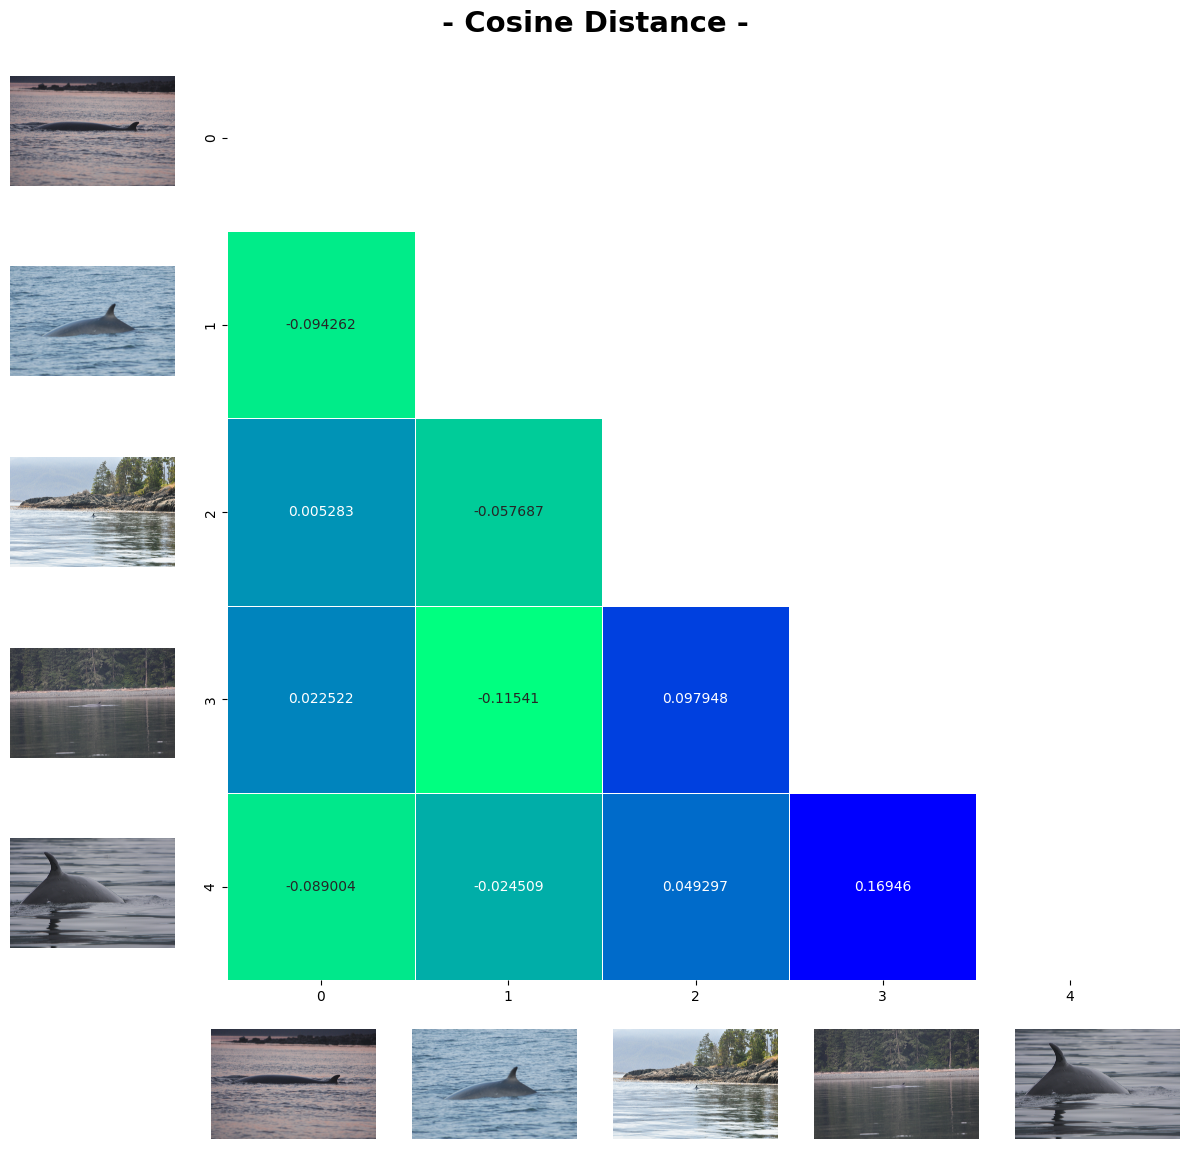

In [18]:


# Plots
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid(shape=(6, 6), loc=(5, 1), colspan=1)
ax2 = plt.subplot2grid(shape=(6, 6), loc=(5, 2), colspan=1)
ax3 = plt.subplot2grid(shape=(6, 6), loc=(5, 3), colspan=1)
ax4 = plt.subplot2grid(shape=(6, 6), loc=(5, 4), colspan=1)
ax5 = plt.subplot2grid(shape=(6, 6), loc=(5, 5), colspan=1)
h_axes = [ax1, ax2, ax3, ax4, ax5]

ax6 = plt.subplot2grid(shape=(6, 6), loc=(0, 0), colspan=1)
ax7 = plt.subplot2grid(shape=(6, 6), loc=(1, 0), colspan=1)
ax8 = plt.subplot2grid(shape=(6, 6), loc=(2, 0), colspan=1)
ax9 = plt.subplot2grid(shape=(6, 6), loc=(3, 0), colspan=1)
ax10 = plt.subplot2grid(shape=(6, 6), loc=(4, 0), colspan=1)
v_axes = [ax6, ax7, ax8, ax9, ax10]

ax11 = plt.subplot2grid(shape=(6, 6), loc=(0, 1), colspan=5, rowspan=5)

fig.suptitle('- Cosine Distance -', size = 21, weight='bold')
for k, ax in enumerate(h_axes):
    ax.imshow(plt.imread(example_paths[k]))
    ax.set_axis_off()
    
for k, ax in enumerate(v_axes):
    ax.imshow(plt.imread(example_paths[k]))
    ax.set_axis_off()
    
sns.heatmap(cos_matrix, ax=ax11, fmt=".5",
            cbar=False, annot=True, linewidths=0.5, mask=mask, square=True, cmap="winter_r")

plt.tight_layout()
plt.show()



In [58]:
# Libraries
import os
import gc
import wandb
import time
import random
import math
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html

from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from albumentations.pytorch import transforms
import albumentations
import timm

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'happywhale', '_wandb_kernel': 'aot'}

In [59]:


def set_seed(seed = 1234):
    '''
    🌱src:https://www.kaggle.com/andradaolteanu/melanoma-competiton-aug-resnet-effnet-lb-0-91
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device", device)



Device cuda


In [60]:
# --------- INITIAL PARAMETERS ---------
TRAIN_FOLDER = "./happy-whale-and-dolphin/train_images/"
TEST_FOLDER = "./happy-whale-and-dolphin/test_images/"

# Set some parameters for sanity checks & experimenting
N_SPLITS = 5
BATCH_SIZE = 16
MODEL_NAME = 'efficientnet_b0'
NUM_CLASSES = 15587
NO_NEURONS = 250
EMBEDDING_SIZE = 128
# -------------------------------------

In [61]:
# Import the data
train = pd.read_csv("./train_keys.csv")
test = pd.read_csv("./happy-whale-and-dolphin/sample_submission.csv")

# Update path to new image folders
train["path"] = TRAIN_FOLDER + train["image"]

widths, heights = [], []

for path in tqdm(train["path"]):
    width, height = imagesize.get(path)
    widths.append(width)
    heights.append(height)
    
train["width"] = widths
train["height"] = heights
train["dimension"] = train["width"] * train["height"]

display_html(train.head(5))

test["path"] = TEST_FOLDER + test["image"]

widths, heights = [], []

for path in tqdm(test["path"]):
    width, height = imagesize.get(path)
    widths.append(width)
    heights.append(height)
    
test["width"] = widths
test["height"] = heights
test["dimension"] = test["width"] * test["height"]
display_html(test.head(5))

100%|███████████████████████████████████████████████████████████████████| 51033/51033 [00:29<00:00, 1746.93it/s]


,image,species,individual_id,class,path,image_code,target,individual_key,kfold,width,height,dimension
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,whale,./happy-whale-and-dolphin/train_images/00021ad...,00021adfb725ed,['00021adfb725ed'],15586,0,804,671,539484
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,whale,./happy-whale-and-dolphin/train_images/0005622...,000562241d384d,['000562241d384d' 'ffae18d2939ffc'],4050,1,3504,2336,8185344
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,whale,./happy-whale-and-dolphin/train_images/0007c33...,0007c33415ce37,['0007c33415ce37' '07b8fac61777d6' '110c832238...,70,0,3599,2399,8634001
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,dolphin,./happy-whale-and-dolphin/train_images/0007d9b...,0007d9bca26a99,['0007d9bca26a99' '0644253c42bc31' '0c7aadd2c8...,68,0,3504,2336,8185344
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,whale,./happy-whale-and-dolphin/train_images/00087ba...,00087baf5cef7a,['00087baf5cef7a' '04014212f46fe2' '0951efa7c4...,112,0,3599,2699,9713701


100%|███████████████████████████████████████████████████████████████████| 27956/27956 [00:18<00:00, 1486.32it/s]


,image,predictions,path,width,height,dimension
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,./happy-whale-and-dolphin/test_images/00011070...,3599,2399,8634001
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,./happy-whale-and-dolphin/test_images/0006287e...,3600,2400,8640000
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,./happy-whale-and-dolphin/test_images/000809ec...,2240,1488,3333120
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,./happy-whale-and-dolphin/test_images/00098d13...,2048,892,1826816
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,./happy-whale-and-dolphin/test_images/000b8d89...,293,319,93467


In [62]:


class HappyWhaleDataset(Dataset):
    
    def __init__(self, csv, trainFlag):
        '''Module to create the PyTorch Dataset.
        csv: full dataframe (train or test)
        trainFlag: True if csv is a training/validation dataset, False otherwise
        return: image and class target if trainFlag, otherwise only image'''
        
        self.csv = csv
        self.trainFlag = trainFlag
        if self.trainFlag:
            self.transform = albumentations.Compose([
                albumentations.Resize(128, 128),
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
                albumentations.Rotate(),
                albumentations.Normalize(),
                # B&W?
            ])
        else:
            self.transform = albumentations.Compose([
                albumentations.Normalize()
            ])

            
    def __len__(self):
        return self.csv.shape[0]

    
    def __getitem__(self, index):
        # Get data
        row = self.csv.iloc[index]
        
        # Read and transform the image
        image = cv2.imread(row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transformed_img = self.transform(image=image)['image'].astype(np.float32)
        image = transformed_img.transpose(2, 0, 1)
        image = torch.tensor(image)            

        if self.trainFlag:
            # Retrieve the target group
            target = torch.tensor(row.individual_key)
            return image, target
        
        else:
            return image



In [63]:
# Example for the Dataset data
example_dataset = HappyWhaleDataset(train.head(12), trainFlag=True)
example_loader = DataLoader(example_dataset, batch_size=3)

for k, (image, target) in enumerate(example_loader):
    print(f"--- Batch {k} ---")
    print("Image Shape:", image.shape)
    print("Target:", target, "\n")

--- Batch 0 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([15586,  4050,    70]) 

--- Batch 1 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([ 68, 112,  11]) 

--- Batch 2 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([ 295, 1870,  178]) 

--- Batch 3 ---
Image Shape: torch.Size([3, 3, 128, 128])
Target: tensor([198,   3,  18]) 



In [64]:


# src: https://amaarora.github.io/2020/08/30/gempool.html

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        # Applies 2D average-pooling operation in kH * kW regions by step size
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'



In [65]:


# src: https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        '''
        in_features: dimension of the input
        out_features: dimension of the last layer (in our case the classification)
        s: norm of input feature
        m: margin
        ls_eps: label smoothing'''
        
        super(ArcMarginProduct, self).__init__()
        self.in_features, self.out_features = in_features, out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        # Fills the input `Tensor` with values according to the method described in
        # `Understanding the difficulty of training deep feedforward neural networks`
        # Glorot, X. & Bengio, Y. (2010)
        # using a uniform distribution.
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m, self.sin_m = math.cos(m), math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        one_hot = torch.zeros(cosine.size()).to(device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output



In [66]:
class HappyWhaleModel(nn.Module):
    def __init__(self, modelName, numClasses, noNeurons, embeddingSize):
        
        super(HappyWhaleModel, self).__init__()
        # Retrieve pretrained weights
        self.backbone = timm.create_model(modelName, pretrained=True)
        # Save the number features from the backbone
        ### different models have different numbers e.g. EffnetB3 has 1536
        backbone_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity() # ?????
        self.backbone.global_pool = nn.Identity() # ?????
        self.gem = GeM()
        # Embedding layer (what we actually need)
        self.embedding = nn.Sequential(nn.Linear(backbone_features, noNeurons),
                                       nn.BatchNorm1d(noNeurons),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.2),
                                       
                                       nn.Linear(noNeurons, embeddingSize),
                                       nn.BatchNorm1d(embeddingSize),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.2))
        self.arcface = ArcMarginProduct(in_features=embeddingSize, 
                                        out_features=numClasses,
                                        s=30.0, m=0.50, easy_margin=False, ls_eps=0.0)
        
        
    def forward(self, image, target=None, prints=False):
        '''If there is a target it means that the model is training on the dataset.
        If there is no target, that means the model is predicting on the test dataset.
        In this case we would skip the ArcFace layer and return only the image embeddings.
        '''
        
        features = self.backbone(image)
        # flatten transforms from e.g.: [3, 1536, 1, 1] to [3, 1536]
        gem_pool = self.gem(features).flatten(1)
        embedding = self.embedding(gem_pool)
        if target != None:
            out = self.arcface(embedding, target)
        
        if prints:
            print("0. IN:", "image shape:", image.shape, "target:", target)
            print("1. Backbone Output:", features.shape)
            print("2. GeM Pool Output:", gem_pool.shape)
            print("3. Embedding Output:", embedding.shape)
            if target != None:
                print("4. ArcFace Output:", out.shape)
        
        if target != None:
            return out, embedding
        else:
            return embedding

In [67]:


# Create an example model - Effnet
model_example = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)



INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [68]:


# Criterion
criterion_example = nn.CrossEntropyLoss()

# We'll use previous datasets & dataloader
for k, (image, target) in enumerate(example_loader):
    print(f"=== Batch {k} ===")
    image, target = image.to(device), target.to(device)
    out, _ = model_example(image, target, prints=True)
    loss = criterion_example(out, target)
    print('--- LOSS ---', loss.item(), "\n")



=== Batch 0 ===
0. IN: image shape: torch.Size([3, 3, 128, 128]) target: tensor([15586,  4050,    70], device='cuda:0')
1. Backbone Output: torch.Size([3, 1280, 4, 4])
2. GeM Pool Output: torch.Size([3, 1280])
3. Embedding Output: torch.Size([3, 128])
4. ArcFace Output: torch.Size([3, 15587])
--- LOSS --- 27.08006477355957 

=== Batch 1 ===
0. IN: image shape: torch.Size([3, 3, 128, 128]) target: tensor([ 68, 112,  11], device='cuda:0')
1. Backbone Output: torch.Size([3, 1280, 4, 4])
2. GeM Pool Output: torch.Size([3, 1280])
3. Embedding Output: torch.Size([3, 128])
4. ArcFace Output: torch.Size([3, 15587])
--- LOSS --- 27.8608455657959 

=== Batch 2 ===
0. IN: image shape: torch.Size([3, 3, 128, 128]) target: tensor([ 295, 1870,  178], device='cuda:0')
1. Backbone Output: torch.Size([3, 1280, 4, 4])
2. GeM Pool Output: torch.Size([3, 1280])
3. Embedding Output: torch.Size([3, 128])
4. ArcFace Output: torch.Size([3, 15587])
--- LOSS --- 26.414403915405273 

=== Batch 3 ===
0. IN: image

In [69]:
del model_example
gc.collect()

16387

In [70]:


# --------- GLOBAL PARAMETERS ---------
NUM_CLASSES = 15587
N_SPLITS = 3
BATCH_SIZE = 32
MODEL_NAME = 'efficientnet_b0'
RUN_NAME = "B0_neurons_200_embed_200_epochs_4"
EPOCHS = 6
VALID_PERC = 0.1
NO_NEURONS = 250
EMBEDDING_SIZE = 128
# -> Optimizer
LR = 0.0001
WEIGHT_DECAY = 0.000001
# -> Scheduler
T_MAX = 500              # Maximum number of iterations
MIN_LR = 0.000001        # Minimum learning rate. Default: 0
# ------------------------------------



In [71]:
def get_loaders(df, train_i, valid_i):
    '''
    df: the full initial dataframe
    train_i, valid_i: list of indexes for train and validation split
    VALID_PERC: percentage of how much of valid data to preserve - leave 1 for full dataset
    return: train_loader and valid_loader
    '''
    
    train_df = df.iloc[train_i, :]
    # To go quicker through validation
    valid_df = df.iloc[valid_i, :].sample(int(len(valid_i)*VALID_PERC), random_state=23)

    # Datasets & Dataloader
    train_dataset = HappyWhaleDataset(train_df, trainFlag=True)
    valid_dataset = HappyWhaleDataset(valid_df, trainFlag=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, valid_loader

In [72]:


def get_model_optimizer_criterion():
    
    model = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)
    optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, amsgrad=False)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=MIN_LR)
    criterion = nn.CrossEntropyLoss()
    
    return model, optimizer, scheduler, criterion



In [73]:


import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses, epochs, fold):
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Graph - Fold {fold}')
    plt.legend()
    plt.show()

In [74]:
def train_pipeline(train):
    '''
    train: the full training dataframe (to be split in train data & valid data)
    '''

    s = time.time()
    
    # 🐝 W&B Initialize  
    RUN_CONFIG = CONFIG.copy()
    params = dict(model=MODEL_NAME, epochs=EPOCHS, split=N_SPLITS, 
                  batch=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
                  t_max=T_MAX, min_lr=MIN_LR)
    RUN_CONFIG.update(params)

    
    # === CV Split ===
    skf = StratifiedKFold(n_splits=N_SPLITS)
    skf_splits = skf.split(X=train, y=train["individual_key"])


    for fold, (train_i, valid_i) in enumerate(skf_splits):

        print("~"*25)
        print("~"*8, f"FOLD {fold}", "~"*8)
        print("~"*25)

        # Retrieve data loaders
        train_loader, valid_loader = get_loaders(train, train_i, valid_i)

        # Model/ Optimizer/ Scheduler/ Criterion
        model, optimizer, scheduler, criterion = get_model_optimizer_criterion()
        model.to(device)
        # Hooks into the torch model to collect gradients and the topology

        # Run Training
        BEST_SCORE = 9999

        for epoch in range(EPOCHS):
            print("~"*8, f"Epoch {epoch}", "~"*8)

            # === TRAIN ===
            model.train()
            train_losses = []

            for images, targets in tqdm(train_loader, desc = 'TRAIN'):
                images, targets = images.to(device), targets.to(device)

                # Clear gradients BEFORE prediction
                optimizer.zero_grad()
                # Make predictions
                out, _ = model(images, targets)
                # Compute Loss and Optimize
                loss = criterion(out, targets)             
                loss.backward()
                optimizer.step()

                train_losses.append(loss.cpu().detach().numpy().tolist())

            # Adjust Learning Rate
            scheduler.step()

            mean_train_loss = np.mean(train_losses)
            print("Mean Train Loss:", mean_train_loss)


            # === EVAL ===
            model.eval()
            valid_losses, valid_preds, valid_targets = [], [], []
            with torch.no_grad():
                for images, targets in valid_loader:
                    valid_targets.append(targets)
                    images, targets = images.to(device), targets.to(device)

                    out, _ = model(images, targets)
                    loss = criterion(out, targets)

                    valid_preds.append(out)
                    valid_losses.append(loss.cpu().detach().numpy().tolist())

            mean_valid_loss = np.mean(valid_losses)
            print("Mean Valid Loss:", mean_valid_loss)
            gc.collect()

            #plot_loss(train_losses, valid_losses, epoch, fold)

            # === UPDATES ===

            if mean_valid_loss < BEST_SCORE:        
                print("! Saving model in fold {} | epoch {} ...".format(fold, epoch), "\n")
                torch.save(model.state_dict(), f"EffNetB0_fold_{fold}_loss_{round(mean_valid_loss, 3)}.pt")

                BEST_SCORE = mean_valid_loss

        # Clean memory before next fold
        del model, optimizer, scheduler, criterion, images, targets, \
                    train_losses, valid_losses, valid_preds, valid_targets
        torch.cuda.empty_cache()
        gc.collect()


    print(f"Time to run: {round((time.time() - s)/60, 2)} minutes")

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ FOLD 0 ~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~ Epoch 0 ~~~~~~~~


TRAIN: 100%|████████████████████████████████████████████████████████████████| 1064/1064 [27:22<00:00,  1.54s/it]


Mean Train Loss: 22.38608467668519
Mean Valid Loss: 17.503238607335973


ValueError: x and y must have same first dimension, but have shapes (0,) and (1064,)

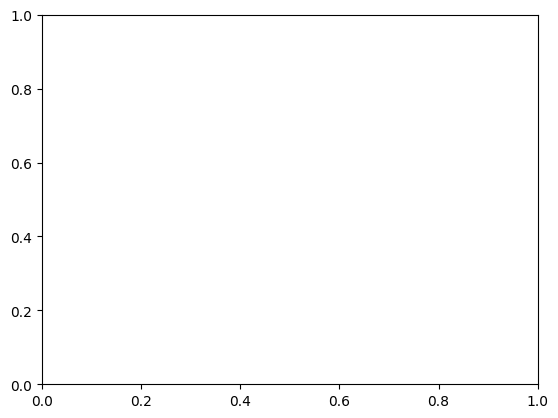

In [75]:


train_pipeline(train)



In [ ]:
classif_model_path = "./EffNetB0_fold_2_loss_16.367.pt"

# Load the model and append learned params
model = HappyWhaleModel(MODEL_NAME, NUM_CLASSES, NO_NEURONS, EMBEDDING_SIZE).to(device)
model.load_state_dict(torch.load(classif_model_path))

In [ ]:


# DataLoader
dataset = HappyWhaleDataset(train, trainFlag=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Retrieve all embeddings for each image
all_embeddings = []

model.eval()
with torch.no_grad():
    for image, target in tqdm(dataloader): 
        image, target = image.to(device), target.to(device)
        _, embedding = model(image, target)
        embedding = embedding.detach().cpu().numpy()
        all_embeddings.append(embedding)
        
# Concatenate batches together
image_embeddings = np.concatenate(all_embeddings)

# Save embeddings and corresponding image
np.save('EffNetB0_fold2.npy', image_embeddings)



In [ ]:


# === CLUSTERING ===
# Use the cuml function from RAPIDS suite
knn_model = NearestNeighbors(n_neighbors=5)
# Train the model
knn_model.fit(image_embeddings)

# Infer on the training data
# distances - the distance between each point in the group
# indices - the index row of each image
distances, indices = knn_model.kneighbors(image_embeddings)



In [ ]:
# === PREDICTION ===
# Create the grouped predictions based on distances & indices
predictions = {"images": [], "embeddings": []}

for i in tqdm(range(len(image_embeddings))):
    index = np.where(distances[k, ] < 6.0)[0]
    split = indices[i, index]
    
    grouped_images = train.iloc[split]["image"].values
    grouped_embeddings = image_embeddings[split]

    predictions["images"].append(grouped_images)
    predictions["embeddings"].append(grouped_embeddings)

In [ ]:


# --------- INFERENCE PARAMETERS ---------
PRETRAINED_NAME1 = "EffNetB0_fold_0_loss_14.979"
PRETRAINED_NAME2 = "EffNetB0_fold_1_loss_14.91"
PRETRAINED_NAME3 = "EffNetB0_fold_2_loss_15.325"
MODEL_NAME = 'efficientnet_b0'
NUM_CLASSES = 15587
NO_NEURONS = 250
EMBEDDING_SIZE = 128
# ----------------------------------------



In [ ]:
dataset = HappyWhaleDataset(test, trainFlag=False)
testLoader = DataLoader(dataset, batch_size=64, shuffle=False)

# Retrieve all embeddings for each image
test_embeddings = []
test_targets = []

with torch.no_grad():
    for img, target in tqdm(testLoader): 
        img = img.to(device)
        img_embedding = model(img)
        img_embedding = img_embedding.detach().cpu().numpy()
        test_embeddings.append(img_embedding)
        test_targets.append(target.numpy())



In [ ]:
train_embeddings = np.load("EffNetB0_fold2.npy")
train_individual_ids = train["individual_id"].values
print("Train Embeddings:", train_embeddings.shape, "\n"+
      "Train Individual Id:", train_individual_ids.shape, "\n")


# Train a final KNN model with the train embeddings
knn_final_model = NearestNeighbors(n_neighbors=50)
knn_final_model.fit(train_embeddings)

# Get distances & indexes for test
# test_embeddings = normalize(test_embeddings, axis=1, norm='l2')

D, I = knn_final_model.kneighbors(test_embeddings)
print("Distances shape:", D.shape, "\n"+
      "Index shape:", I.shape)

# List of the test dataframe image ids (to loop through it)
test_images = test["image"].tolist()

In [ ]:


test_df = []

# Loop through each observation within test data
for k, image_id in tqdm(enumerate(test_images)):
    # Get individual_id & distances for the observation
    individual_id = train_individual_ids[I[k]]
    distances = D[k]
    # Create a df subset with this info
    subset_preds = pd.DataFrame(np.stack([individual_id, distances], axis=1),
                                columns=['individual_id','distances'])
    subset_preds['image_id'] = image_id
    test_df.append(subset_preds)
    
    
# Concatenate subset dataframes into 1 dataframe
test_df = pd.concat(test_df).reset_index(drop=True)
# Choose max distance for each unique pair of individual_id & image_id
test_df = test_df.groupby(['image_id','individual_id'])['distances'].max().reset_index()



In [ ]:
# Have a look at the predictions dataset now
test_df.sample(n=5, random_state=24)

In [ ]:


# ===== III. PREDICTION  =====

# Dictionary in format: {["image_id"]: 000, ["individual_id"]: 9999}
predictions = {}
thresh = 5

for k, row in tqdm(test_df.iterrows()):
    image_id = row["image_id"]
    individual_id = row["individual_id"]
    distance = row["distances"]
    
    # If the image_id has already been added in predictions before
    if image_id in predictions:
        # If total preds for this image_id are < 5 then add, else continue
        if len(predictions[image_id]) != 5:
            predictions[image_id].append(individual_id)
        else:
            continue
    # If the distance is greater than thresh add prediction + "new_individual"
    elif distance > thresh:
        predictions[image_id] = [individual_id, "new_individual"]
    else:
        predictions[image_id] = ["new_individual", individual_id]


# Fill in all lists that have less than 5 predictions as of yet
sample_list = ['37c7aba965a5', '114207cab555', 'a6e325d8e924', '19fbb960f07d','c995c043c353']

for image_id, preds in tqdm(predictions.items()):
    if len(preds) < 5:
        remaining = [individ_id for individ_id in sample_list if individ_id not in preds]
        preds.extend(remaining)
        predictions[image_id] = preds[:5]



In [ ]:
# Create final submission
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions['predictions'] = predictions['predictions'].apply(lambda x: ' '.join(x))
predictions.to_csv('submission.csv',index=False)

predictions.head()